<a href="https://colab.research.google.com/github/BKover99/spatialAUC/blob/main/Tutorials/spatialAUC_tutorial_Xenium_whole_mouse_pup.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Downloading spatial transcriptomic and imaging data.

In [1]:
!wget https://s3-us-west-2.amazonaws.com/10x.files/samples/xenium/1.6.0/Xenium_V1_mouse_pup/Xenium_V1_mouse_pup_outs.zip

--2024-10-12 16:20:03--  https://s3-us-west-2.amazonaws.com/10x.files/samples/xenium/1.6.0/Xenium_V1_mouse_pup/Xenium_V1_mouse_pup_outs.zip
Resolving s3-us-west-2.amazonaws.com (s3-us-west-2.amazonaws.com)... 52.92.146.40, 52.92.236.200, 52.92.204.184, ...
Connecting to s3-us-west-2.amazonaws.com (s3-us-west-2.amazonaws.com)|52.92.146.40|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 63763679465 (59G) [application/zip]
Saving to: ‘Xenium_V1_mouse_pup_outs.zip’

Xenium_V1_mouse_pup 100%[===================>]  59.38G  23.9MB/s    in 45m 46s 

2024-10-12 17:05:50 (22.1 MB/s) - ‘Xenium_V1_mouse_pup_outs.zip’ saved [63763679465/63763679465]



In [2]:
!unzip /content/Xenium_V1_mouse_pup_outs.zip

Archive:  /content/Xenium_V1_mouse_pup_outs.zip
  inflating: cell_feature_matrix.h5  
 extracting: cell_feature_matrix.zarr.zip  
 extracting: analysis.zarr.zip       
  inflating: cells.csv.gz            
  inflating: cells.parquet           
 extracting: cells.zarr.zip          
  inflating: cell_boundaries.csv.gz  
  inflating: cell_boundaries.parquet  
 extracting: transcripts.zarr.zip    
  inflating: transcripts.csv.gz      
  inflating: transcripts.parquet     
  inflating: morphology.ome.tif      
  inflating: morphology_mip.ome.tif  
  inflating: morphology_focus.ome.tif  
  inflating: nucleus_boundaries.csv.gz  
  inflating: nucleus_boundaries.parquet  
  inflating: analysis_summary.html   
  inflating: experiment.xenium       
  inflating: metrics_summary.csv     
  inflating: gene_panel.json         
  inflating: analysis.tar.gz         
  inflating: cell_feature_matrix.tar.gz  


Installing packages

In [ ]:
!pip install numpy
!pip install pseudovisium
!pip install spatialAUC


Loading packages

In [2]:
import squidpy as sq
import scanpy as sc
import numpy as np

/usr/local/lib/python3.10/dist-packages/cudf/utils/_ptxcompiler.py:61: UserWarning: Error getting driver and runtime versions:

stdout:



stderr:

Traceback (most recent call last):
  File "<string>", line 4, in <module>
  File "/usr/local/lib/python3.10/dist-packages/numba/cuda/cudadrv/driver.py", line 295, in __getattr__
    raise CudaSupportError("Error at driver init: \n%s:" %
numba.cuda.cudadrv.error.CudaSupportError: Error at driver init: 

CUDA driver library cannot be found.
If you are sure that a CUDA driver is installed,
try setting environment variable NUMBA_CUDA_DRIVER
with the file path of the CUDA driver shared library.
:


Not patching Numba
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/cudf/utils/gpu_utils.py:62: UserWarning: Function "cuInit" not found
  warnings.warn(str(e))


## Running pseudovisium_generate to perform hexagonal binning

In [ ]:
from Pseudovisium.pseudovisium_generate import generate_pv
csv_file = "/content/transcripts.csv.gz"

output_path = "/content"
hexagon_size = 50
pseudovisium_path = generate_pv(csv_file=csv_file,
                                hexagon_size=hexagon_size,
                                output_path=output_path,
                                  batch_size=2000000,
                                technology="Xenium",
                                max_workers=10,
                                quality_filter=True,
                                quality_per_hexagon=False,
                                quality_per_probe=False,
                                tissue_hires_scalef=0.05,
                                project_name='mouse')

## Creating anndata object and quick plot showing sum transcript abundance per hexagon

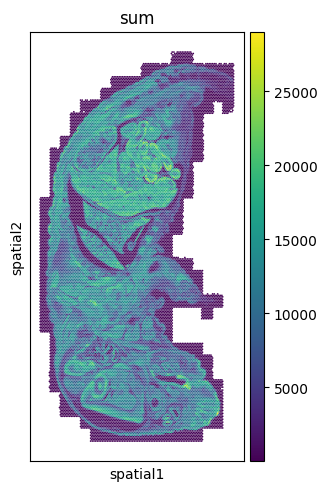

In [3]:
mouse_pup_pv = sq.read.visium("/content/pseudovisium/mouse/", library_id="library_id")
mouse_pup_pv.obs["sum"]= np.array(np.sum(mouse_pup_pv.X,axis=1)).flatten()
sq.pl.spatial_scatter(
    mouse_pup_pv,color="sum",img=False
)

Also printing the fake H&E. If you want the real H&E then you should supply it to pseudovisium_generate, like in https://github.com/BKover99/Pseudovisium/blob/main/Tutorials/Xenium_Tutorial.ipynb .

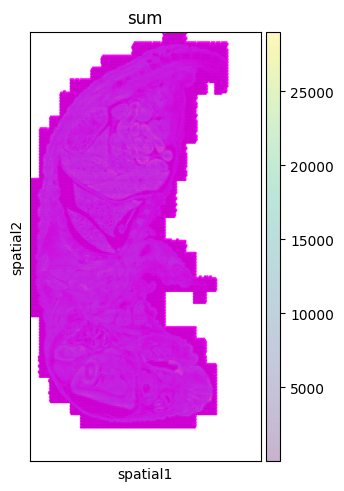

In [4]:
sq.pl.spatial_scatter(
    mouse_pup_pv,color="sum",img=True,alpha=0.3
)

In [5]:
adata_pv = sq.read.visium("/content/pseudovisium/mouse",library_id="library_id")
sc.pp.filter_genes(adata_pv, min_cells=50)
sc.pp.filter_cells(adata_pv, min_counts=100)
sc.pp.normalize_total(adata_pv, target_sum=1e4)
sc.pp.neighbors(adata_pv, n_neighbors=30, n_pcs=20)
sq.gr.spatial_neighbors(adata_pv, radius=250, coord_type="generic", delaunay=True)
adata_pv

/usr/local/lib/python3.10/dist-packages/scanpy/tools/_utils.py:41: UserWarning: You’re trying to run this on 532 dimensions of `.X`, if you really want this, set `use_rep='X'`.
         Falling back to preprocessing with `sc.pp.pca` and default params.
  warnings.warn(


AnnData object with n_obs × n_vars = 19778 × 532
    obs: 'in_tissue', 'array_row', 'array_col', 'n_counts'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells'
    uns: 'spatial', 'pca', 'neighbors', 'spatial_neighbors'
    obsm: 'spatial', 'X_pca'
    varm: 'PCs'
    obsp: 'distances', 'connectivities', 'spatial_connectivities', 'spatial_distances'

Given the very small gene panel, we can be generous with the filtering, and keep gene sets with only 10% of genes represented in the dataset (normally not a very good idea, and a default of 30-50% should be used).

In [6]:
from spatialAUC.spatialAUC import get_df_from_gmt
genes = adata_pv.var_names
df = get_df_from_gmt(['m5.all', 'm2.all'], '2023.1.Mm', genes,min_gene_ratio=0.1, min_gene_count=5)
df

/usr/local/lib/python3.10/dist-packages/gseapy/msigdb.py:20: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  d = pd.read_html(resp.text)[0]
/usr/local/lib/python3.10/dist-packages/gseapy/msigdb.py:72: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  d = pd.read_html(resp.text)[0]


,gene_set,genes,gene_present,total_genes,gene_names_present
0,GOBP_MONOCYTE_CHEMOTAXIS,"[Msmp, Ccl21b, Ano6, Aif1, App, Ccr1, Ccr1l1, ...",6,59,"[S100a14, Ccn3, Ccl12, Ccl9, Ctsg, Nbl1]"
1,GOBP_SUPEROXIDE_METABOLIC_PROCESS,"[Acp5, Agt, Agtr1a, Akt1, Apoa4, App, Atp7a, C...",7,69,"[Mpo, Sod3, Fbln5, Cd36, Cybb, Ncf4, Nox4]"
2,GOBP_WATER_TRANSPORT,"[Slc14a1, Aqp1, Aqp2, Aqp3, Aqp4, Aqp5, Aqp6, ...",8,20,"[Aqp3, Aqp4, Slc14a1, Aqp5, Slc5a1, Aqp1, Aqp7..."
3,GOBP_COMPLEMENT_ACTIVATION,"[C7, C8b, Cfd, Cd5l, Serping1, C1qa, C1qb, C1q...",6,58,"[Colec11, Hc, Cfh, Cd5l, Fcnb, C3]"
4,GOBP_UREA_TRANSPORT,"[Slc14a1, Aqp3, Aqp7, Aqp8, Pou3f3, Slc12a1, U...",6,10,"[Aqp3, Slc14a1, Pou3f3, Slc14a2, Aqp7, Upk3a]"
5,GOBP_PEPTIDE_CROSS_LINKING,"[Cstdc5, Cstdc6, Dsp, Bgn, Col3a1, Dcn, Epb42,...",7,45,"[Ivl, Cstdc4, Bgn, Stfa2l1, Mamdc2, Lor, F13a1]"
6,GOBP_ONE_CARBON_COMPOUND_TRANSPORT,"[Slc14a1, Aqp1, Aqp3, Aqp4, Aqp5, Aqp6, Aqp7, ...",12,41,"[Aqp3, Aqp4, Slc14a1, Aqp5, Pou3f3, Slc14a2, C..."
7,GOBP_WATER_HOMEOSTASIS,"[Atp6v1b1, Adcy6, Akr1b3, Anxa7, Aqp1, Aqp2, A...",6,34,"[Sct, Aqp3, Atp6v1b1, Aqp4, Aqp1, Aqp7]"
8,GOBP_NEGATIVE_REGULATION_OF_BMP_SIGNALING_PATHWAY,"[Abl1, Cav1, Cer1, Chrd, Dkk1, Dlx1, Fbn1, Fzd...",7,58,"[Cav1, Sostdc1, Lrp2, Htra3, Tnfaip6, Sfrp1, N..."
9,GOBP_NEUTROPHIL_CHEMOTAXIS,"[Ccl21b, Ccl21d, Itga9, Nckap1l, Gbf1, Itga1, ...",11,105,"[Ppbp, Csf3r, Rac2, Ccl12, Thbs4, Pf4, Ccl9, B..."


Let's plot the results. My favourite ones are the kidney ones!

In [7]:
import scanpy as sc
from spatialAUC.spatialAUC import spatial_auc

morans_table, adata_updated = spatial_auc(adata_pv, gene_sets=["m5.all", "m2.all"],min_gene_ratio=0.1, min_gene_count=5)

# Access the results
morans_table

Getting gene set


/usr/local/lib/python3.10/dist-packages/gseapy/msigdb.py:20: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  d = pd.read_html(resp.text)[0]
/usr/local/lib/python3.10/dist-packages/gseapy/msigdb.py:72: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  d = pd.read_html(resp.text)[0]


Calculating AUC


Calculating AUC: 100%|██████████| 41/41 [00:10<00:00,  3.73gene set/s]


Calculating Moran's I


  0%|          | 0/1000 [00:00<?, ?/s]

Filtering gene sets
Generating fake gene sets
Calculating empirical p-values


Calculating AUC: 100%|██████████| 1000/1000 [03:31<00:00,  4.72gene set/s]


Calculating Moran's I for fake gene sets


  0%|          | 0/1000 [00:00<?, ?/s]

,I,pval_norm,var_norm,pval_z_sim,pval_sim,var_sim,pval_norm_fdr_bh,pval_z_sim_fdr_bh,pval_sim_fdr_bh,contributing_genes,n_contributing_genes,p_empirical
GOCC_BRUSH_BORDER_MEMBRANE,0.741993,0.0,0.000017,0.0,0.000999,0.000040,0.0,0.0,0.000999,"[Lrp2, Slc34a2, Ace2, Cubn, Cd36, Cdhr5, Aqp1,...",9,0.000
GOBP_COMPLEMENT_ACTIVATION,0.726278,0.0,0.000017,0.0,0.000999,0.000038,0.0,0.0,0.000999,"[Colec11, Hc, Cfh, Cd5l, Fcnb, C3]",6,0.002
GOCC_COLLAGEN_CONTAINING_EXTRACELLULAR_MATRIX,0.720701,0.0,0.000017,0.0,0.000999,0.000036,0.0,0.0,0.000999,"[Clec14a, Ambp, Comp, Serpinf1, Sftpd, Fcnb, P...",44,0.006
GOMF_EXTRACELLULAR_MATRIX_STRUCTURAL_CONSTITUENT,0.720356,0.0,0.000017,0.0,0.000999,0.000037,0.0,0.0,0.000999,"[Col8a1, Col2a1, Marco, Comp, Vwf, Prg2, Mmrn1...",18,0.006
GOBP_NEGATIVE_REGULATION_OF_BMP_SIGNALING_PATHWAY,0.667465,0.0,0.000017,0.0,0.000999,0.000034,0.0,0.0,0.000999,"[Cav1, Sostdc1, Lrp2, Htra3, Tnfaip6, Sfrp1, N...",7,0.037
GOBP_RENAL_ABSORPTION,0.645804,0.0,0.000017,0.0,0.000999,0.000035,0.0,0.0,0.000999,"[Cldn4, Aqp4, Aqp3, Guca2b, Slc5a1, Kcnj1, Aqp...",8,0.062
GOBP_POSITIVE_REGULATION_OF_WOUND_HEALING,0.634302,0.0,0.000017,0.0,0.000999,0.000033,0.0,0.0,0.000999,"[Cldn4, F3, Hrg, Cd36, Cldn3, Mylk, Reg3g]",7,0.076
GOBP_STRIATED_MUSCLE_CELL_DEVELOPMENT,0.626086,0.0,0.000017,0.0,0.000999,0.000031,0.0,0.0,0.000999,"[Myl9, Myoz1, Mylk3, Prox1, Krt8, Ttn, Krt19, ...",8,0.089
GOMF_FIBRONECTIN_BINDING,0.609455,0.0,0.000017,0.0,0.000999,0.000032,0.0,0.0,0.000999,"[Comp, Thbs4, Mmp9, Igfbp6, Ccdc80, Ctss, Tnfa...",7,0.116
GOCC_CORNIFIED_ENVELOPE,0.604979,0.0,0.000017,0.0,0.000999,0.000033,0.0,0.0,0.000999,"[Serpinb5, Cnfn, Anxa2, Krt16, Ivl, Cstdc4, Lo...",8,0.129


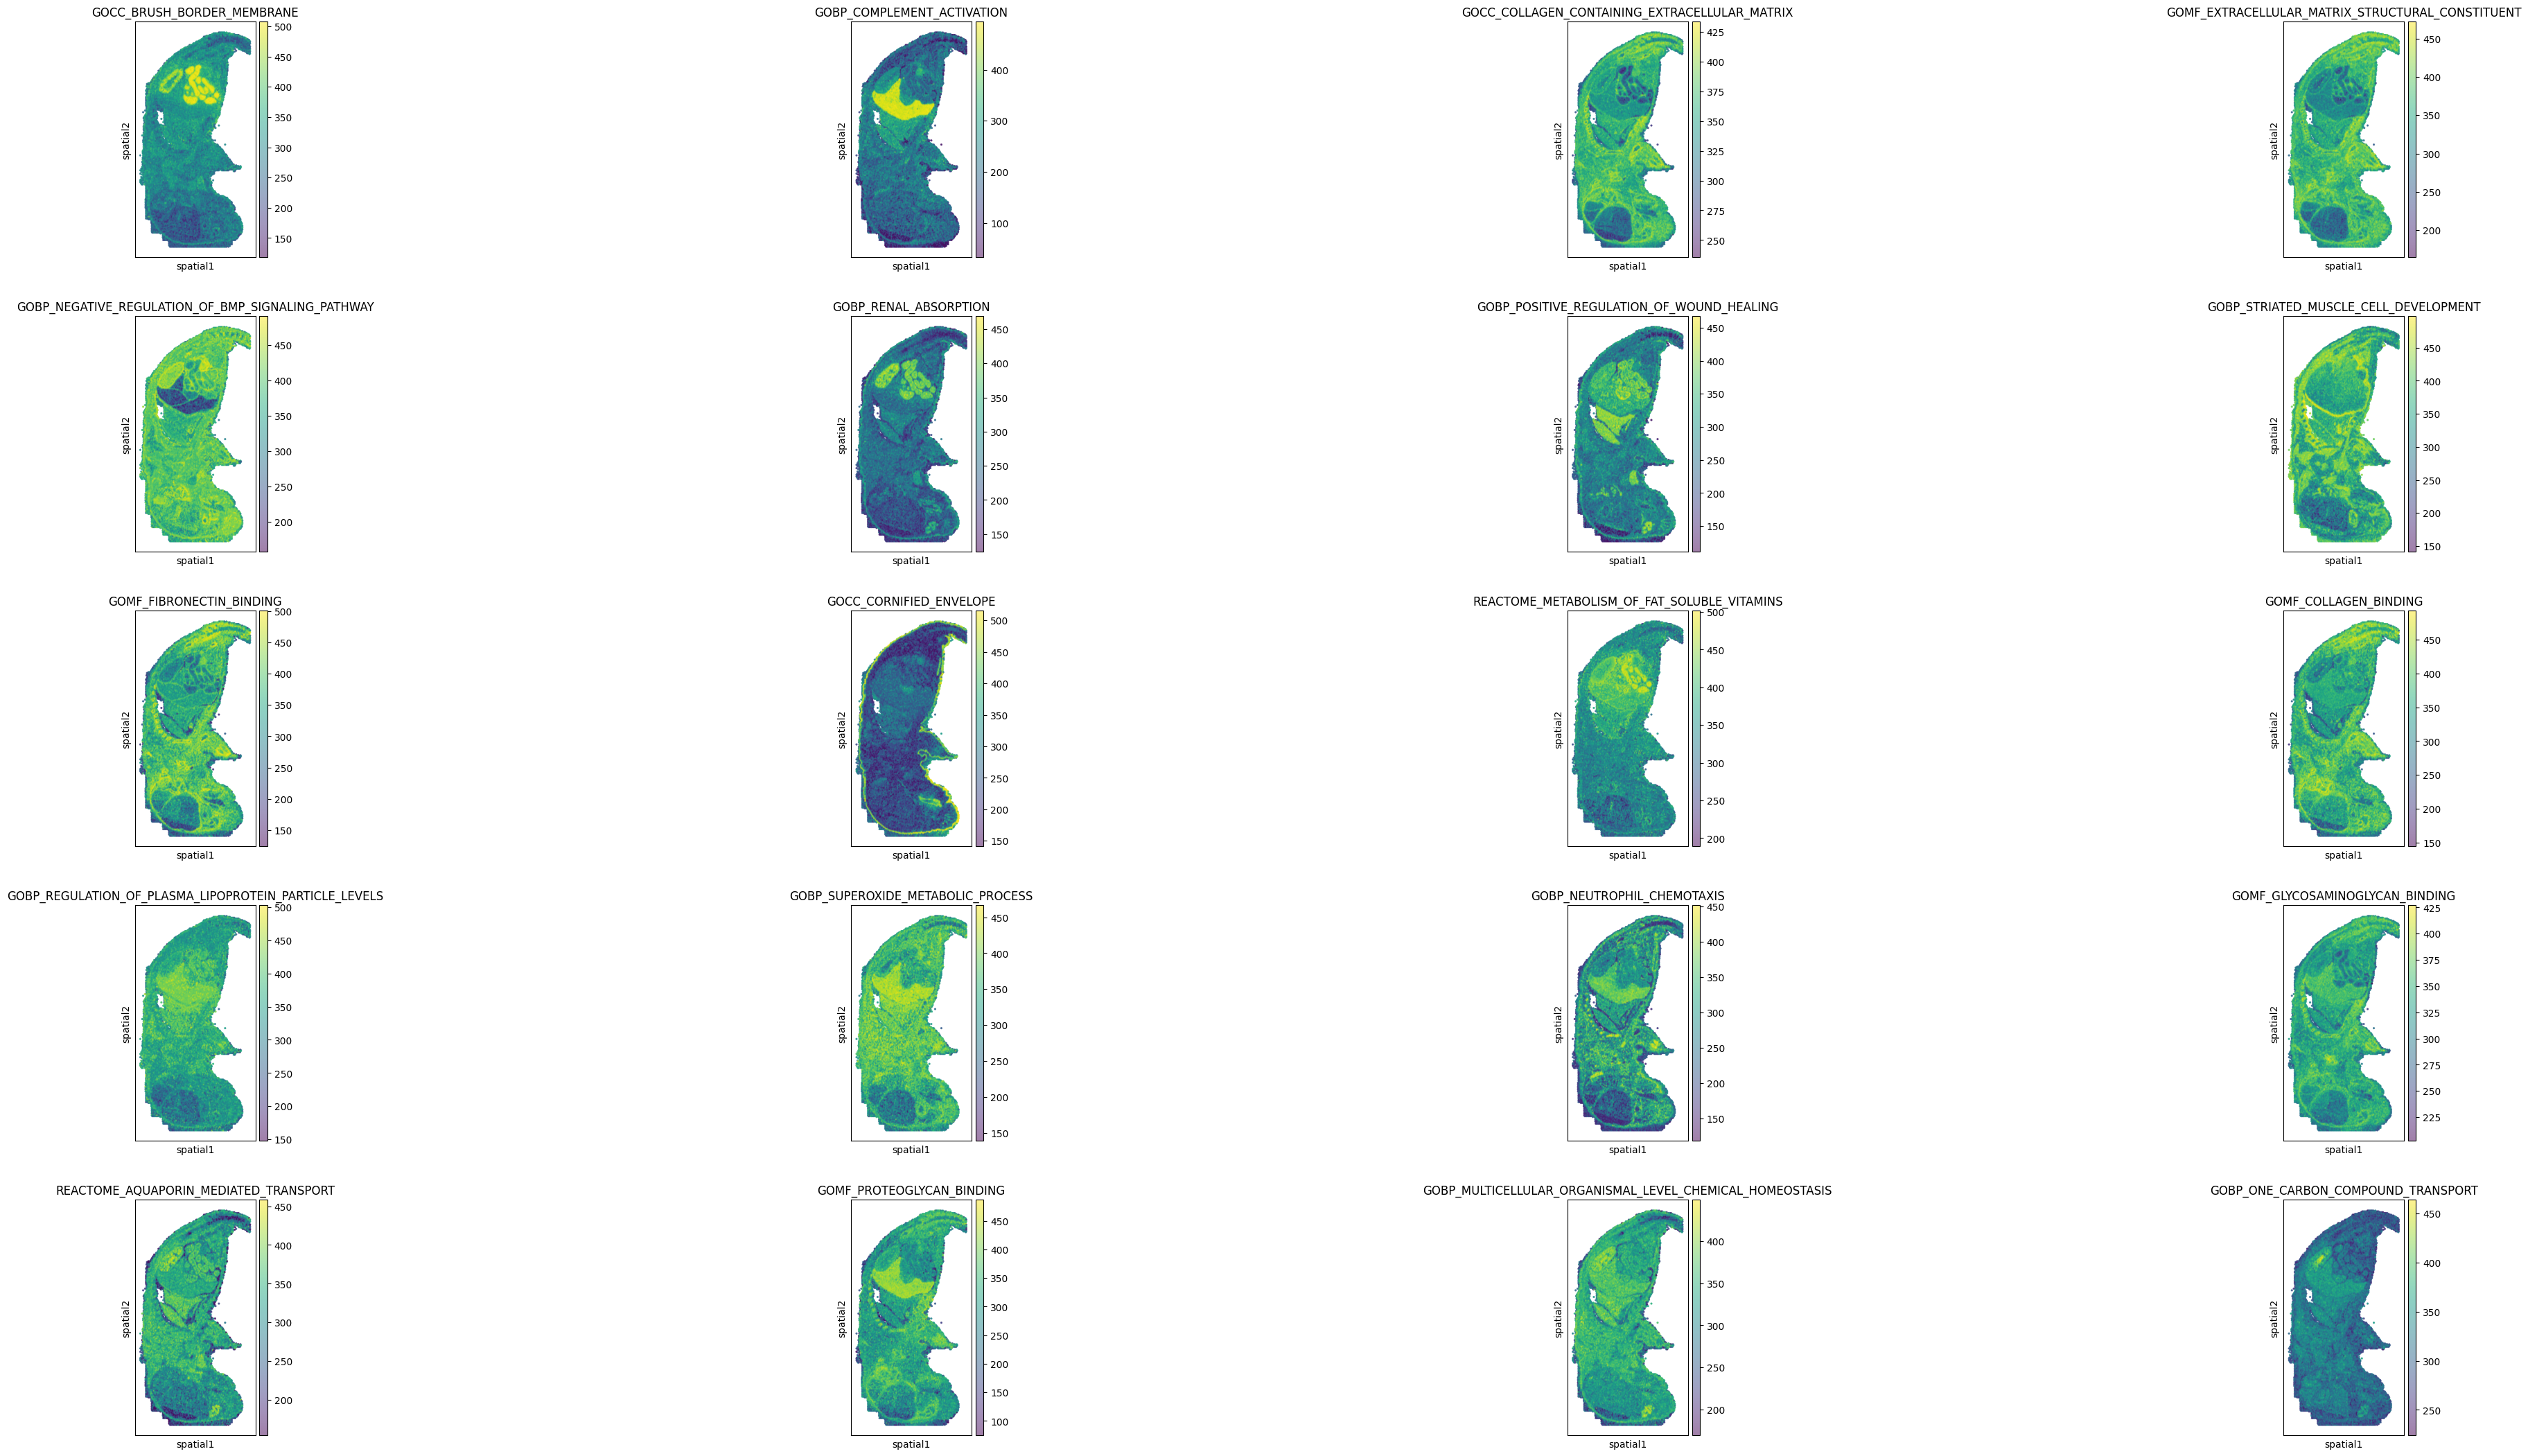

In [8]:
sq.pl.spatial_scatter(
        adata_updated, library_id="spatial", shape=None, color=morans_table.head(20).index.values,
        img=True, alpha=0.5, wspace=0.8
    )